In [1]:
## import necessary modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2




In [2]:
# Load the image directories
path = "C:/Brain tumor/Brain tumor dataset"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

# Get the paths for 'yes' and 'no' folders
yes_folder = os.path.join(path, 'yes')
no_folder = os.path.join(path, 'no')

# Get the image paths for both 'yes' and 'no' folders
yes_images = list(paths.list_images(yes_folder))
no_images = list(paths.list_images(no_folder))

['no', 'yes']
1297


Total Tumor Images: 901
Total Non-Tumor Images: 396
Tumor Proportion: 0.69
Non-Tumor Proportion: 0.31


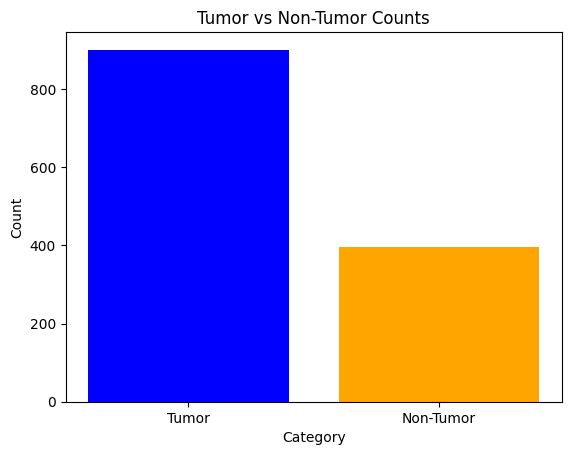

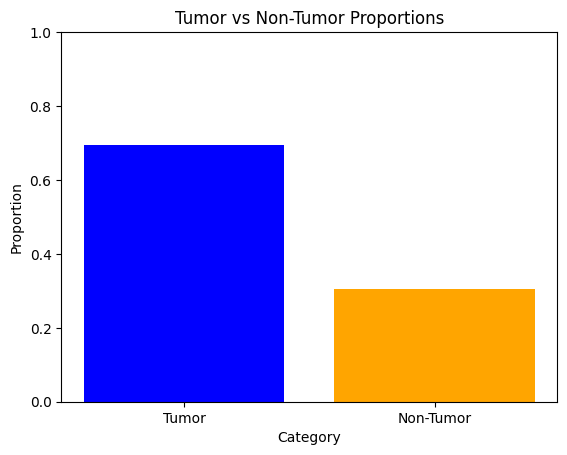

In [3]:
images = []
labels = []

# Load 'yes' images (Tumor)
for image_path in yes_images:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (350, 350))  # Resize to 350x350 pixels as mentioned
    images.append(image)
    labels.append(1)  # Label '1' for Tumor

# Load 'no' images (Non-Tumor)
for image_path in no_images:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (350, 350))  # Resize to 350x350 pixels
    images.append(image)
    labels.append(0)  # Label '0' for Non-Tumor

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Calculate counts for Tumor and Non-Tumor
tumor_count = np.sum(labels == 1)
non_tumor_count = np.sum(labels == 0)

# Calculate proportions
total_images = len(labels)
tumor_proportion = tumor_count / total_images
non_tumor_proportion = non_tumor_count / total_images

# Print the counts and proportions
print(f"Total Tumor Images: {tumor_count}")
print(f"Total Non-Tumor Images: {non_tumor_count}")
print(f"Tumor Proportion: {tumor_proportion:.2f}")
print(f"Non-Tumor Proportion: {non_tumor_proportion:.2f}")

# Create a bar graph to visualize the data
categories = ['Tumor', 'Non-Tumor']
counts = [tumor_count, non_tumor_count]
proportions = [tumor_proportion, non_tumor_proportion]

# Plot the bar graph for counts
plt.bar(categories, counts, color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Tumor vs Non-Tumor Counts')
plt.show()

# Plot the bar graph for proportions
plt.bar(categories, proportions, color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.title('Tumor vs Non-Tumor Proportions')
plt.ylim([0, 1])  # Proportions are between 0 and 1
plt.show()

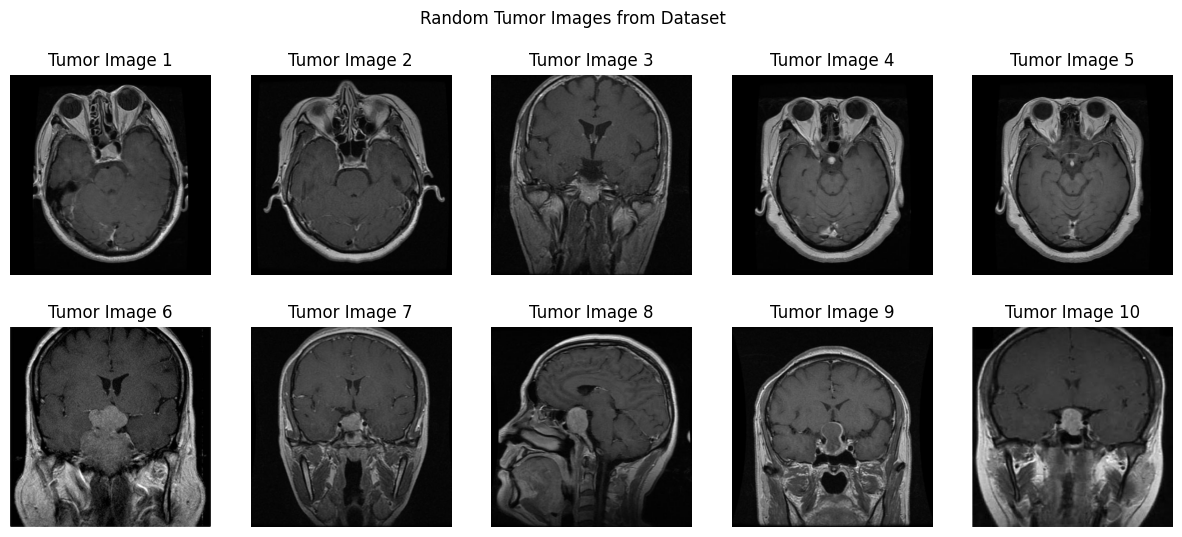

In [4]:

# Load and preprocess tumor images
tumor_images = []
for image_path in paths.list_images(yes_folder):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (350, 350))  # Resize images to 350x350 pixels
    tumor_images.append(image)

# Convert the list of tumor images into a Numpy array
tumor_images = np.array(tumor_images)

# Visualize random images from the tumor dataset
# Select 6 random images to display
num_images = 10
random_indices = np.random.choice(len(tumor_images), num_images, replace=False)
random_images = tumor_images[random_indices]

# Update grid dimensions to fit 10 images (2 rows, 5 columns)
plt.figure(figsize=(15, 6))
for i, img in enumerate(random_images, start=1):  # Start numbering from 1
    plt.subplot(2, 5, i)  # 2 rows, 5 columns
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
    plt.axis('off')
    plt.title(f"Tumor Image {i}")  # Dynamically set title for each image

plt.suptitle("Random Tumor Images from Dataset")
plt.show()



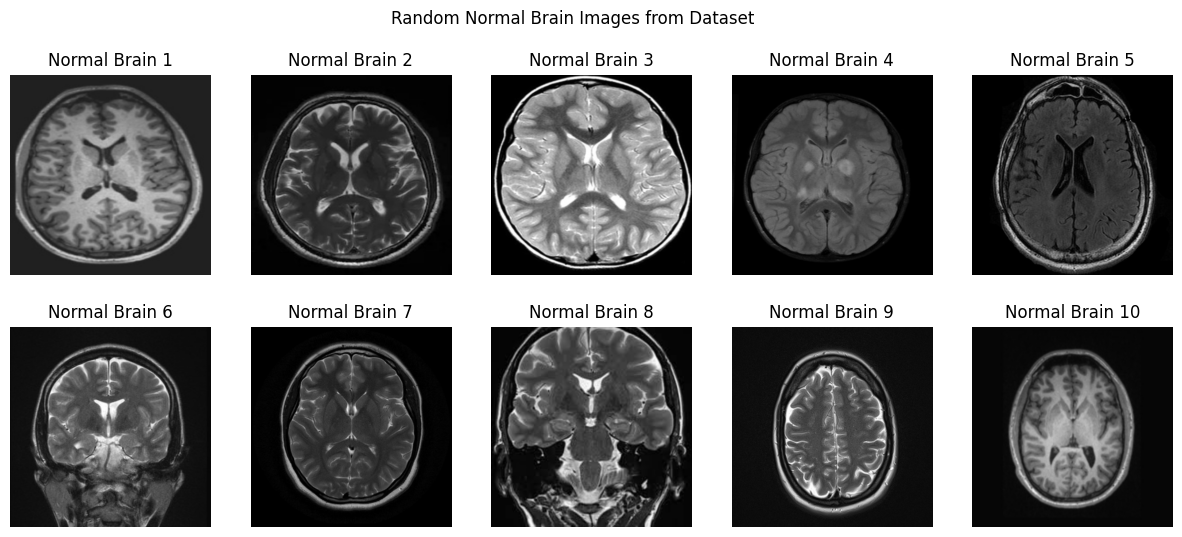

In [5]:
# Load and preprocess non-tumor (normal brain) images
non_tumor_images = []
for image_path in no_images:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (350, 350))  # Resize images to 350x350 pixels
    non_tumor_images.append(image)  # Append to non_tumor_images, not tumor_images

# Convert the list of non-tumor images into a Numpy array
non_tumor_images = np.array(non_tumor_images)

# Visualize random images from the non-tumor dataset
# Select 6 random images to display
num_images = 10
random_indices = np.random.choice(len(non_tumor_images), num_images, replace=False)
random_images = non_tumor_images[random_indices]

# Plot the random images with numbered titles
plt.figure(figsize=(15, 6))  # Adjust the figure size to fit more images horizontally
for i, img in enumerate(random_images, start=1):  # Start numbering from 1
    plt.subplot(2, 5, i)  # 2 rows, 5 columns to fit 10 images
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
    plt.axis('off')
    plt.title(f"Normal Brain {i}")  # Dynamically set title for each image

plt.suptitle("Random Normal Brain Images from Dataset")
plt.show()


In [6]:
# run with uncomment below codes only if any change needed in training data splitting purge or clean
# del trainX
# del trainY
# del model


In [7]:
import gc
gc.collect()


26207

In [8]:
from tensorflow.keras import backend as K
K.clear_session()


In [9]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()


In [10]:
# Load and preprocess tumor images
tumor_images = []
for image_path in paths.list_images(yes_folder):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, (350, 350))  # Resize images to 350x350 pixels
        tumor_images.append(image)
tumor_images = np.array(tumor_images)  # Convert to a numpy array

# Load and preprocess non-tumor images
non_tumor_images = []
for image_path in paths.list_images(no_folder):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, (350, 350))  # Resize images to 350x350 pixels
        non_tumor_images.append(image)
non_tumor_images = np.array(non_tumor_images)  # Convert to a numpy array

# Check that both arrays have the same shape
print("Tumor images shape:", tumor_images.shape)
print("Non-tumor images shape:", non_tumor_images.shape)

# Combine images and labels
images = np.concatenate([tumor_images, non_tumor_images], axis=0)
labels = np.concatenate([np.ones(len(tumor_images)), np.zeros(len(non_tumor_images))], axis=0)

# Confirm shapes
print("Combined images shape:", images.shape)
print("Labels shape:", labels.shape)

# Split data: 80% training, 20% validation
trainX, valX, trainY, valY = train_test_split(images, labels, test_size=0.2, random_state=42)


Tumor images shape: (901, 350, 350, 3)
Non-tumor images shape: (396, 350, 350, 3)
Combined images shape: (1297, 350, 350, 3)
Labels shape: (1297,)


In [11]:
import pickle  # To save the training history
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define the batch size
batch_size = 32

# Assuming 'trainX', 'valX', 'trainY', and 'valY' are already defined and preprocessed

# Data augmentation for training
train_datagen = ImageDataGenerator(
    fill_mode='nearest', rotation_range=1
)

val_datagen = ImageDataGenerator()

# Create the models to train
model_architectures = {
    'VGG16': VGG16(weights="imagenet", include_top=False, input_shape=(350, 350, 3)),
    'ResNet50': ResNet50(weights="imagenet", include_top=False, input_shape=(350, 350, 3)),
    'InceptionV3': InceptionV3(weights="imagenet", include_top=False, input_shape=(350, 350, 3)),
    'MobileNetV2': MobileNetV2(weights="imagenet", include_top=False, input_shape=(350, 350, 3)),
    'DenseNet121': DenseNet121(weights="imagenet", include_top=False, input_shape=(350, 350, 3))
}

# Model training parameters
epochs = 10
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-3)

# Dictionary to store the history of each model
model_histories = {}
model_accuracies = {}
trained_models = {}

# Loop through each model, train, and save it, print and dictionary
for model_name, base_model in model_architectures.items():
    print(f"\nTraining {model_name}...")
    
    # Add custom layers on top of the base model
    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4))(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    # Generate batches of augmented data
    train_data = train_datagen.flow(trainX, trainY, batch_size=batch_size)
    val_data = val_datagen.flow(valX, valY, batch_size=batch_size)

    # Define the checkpoint with the model-specific filename
    checkpoint = ModelCheckpoint(f'{model_name}_best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

    # Model training
    history = model.fit(
        train_data,
        steps_per_epoch=len(trainX) // batch_size,
        validation_data=val_data,
        validation_steps=len(valX) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint, lr_scheduler]
    )

    # Save the final model
    model.save(f"{model_name}_Tumor_detection.h5")
    print(f"{model_name} model saved!")

    # Save the history in the dictionary
    trained_models[model_name] = model
    model_histories[model_name] = history.history  # Store history for later

    # Save the last validation accuracy in a separate dictionary
    last_accuracy = history.history['val_accuracy'][-1]
    model_accuracies[model_name] = last_accuracy

    # Save last accuracy to a file
    with open(f'{model_name}_last_accuracy.pkl', 'w') as f:
        f.write(f"Final Validation Accuracy for {model_name} Model: {last_accuracy}\n")

    
     # Save history to a file for later usage
    with open(f'{model_name}_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)
    
    print(f"{model_name} model and history saved!")

print(f"Final Validation Accuracy for {model_name} Model: {last_accuracy}")
# Example access to the histories for plotting
# You can access the history like model_histories['VGG16']['accuracy'] or model_histories['VGG16']['val_accuracy']



Training VGG16...
Epoch 1/10
32/32 [==============================] - 42s 933ms/step - loss: 1.5479 - accuracy: 0.8249 - val_loss: 0.3342 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 26s 796ms/step - loss: 0.1271 - accuracy: 0.9622 - val_loss: 0.1363 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 25s 790ms/step - loss: 0.0675 - accuracy: 0.9791 - val_loss: 0.1068 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 26s 791ms/step - loss: 0.0344 - accuracy: 0.9871 - val_loss: 0.1092 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 25s 784ms/step - loss: 0.0277 - accuracy: 0.9891 - val_loss: 0.1067 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 25s 789ms/step - loss: 0.0315 - accuracy: 0.9871 - val_loss: 0.0829 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/10
32/32 [===========================

9/9 [==============================] - 4s 474ms/step
VGG16 - Mean Squared Error (MSE): 0.04230769230769231
VGG16 - Root Mean Squared Error (RMSE): 0.20568833780186058


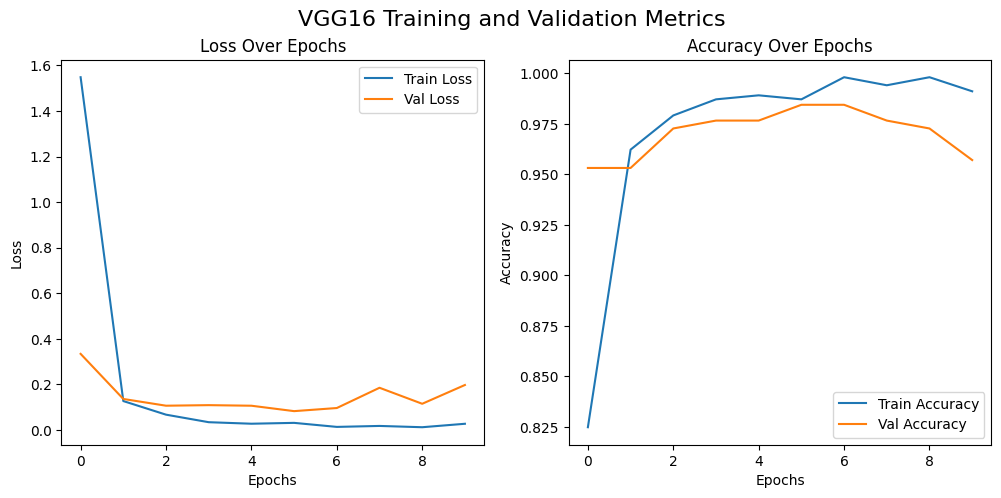

9/9 [==============================] - 2s 164ms/step
ResNet50 - Mean Squared Error (MSE): 0.015384615384615385
ResNet50 - Root Mean Squared Error (RMSE): 0.12403473458920845


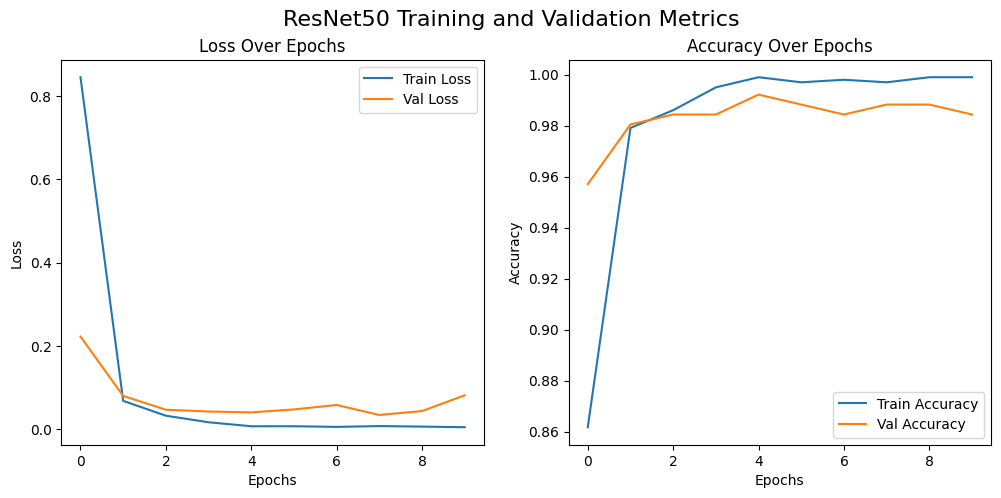

9/9 [==============================] - 3s 197ms/step
InceptionV3 - Mean Squared Error (MSE): 0.03461538461538462
InceptionV3 - Root Mean Squared Error (RMSE): 0.1860521018838127


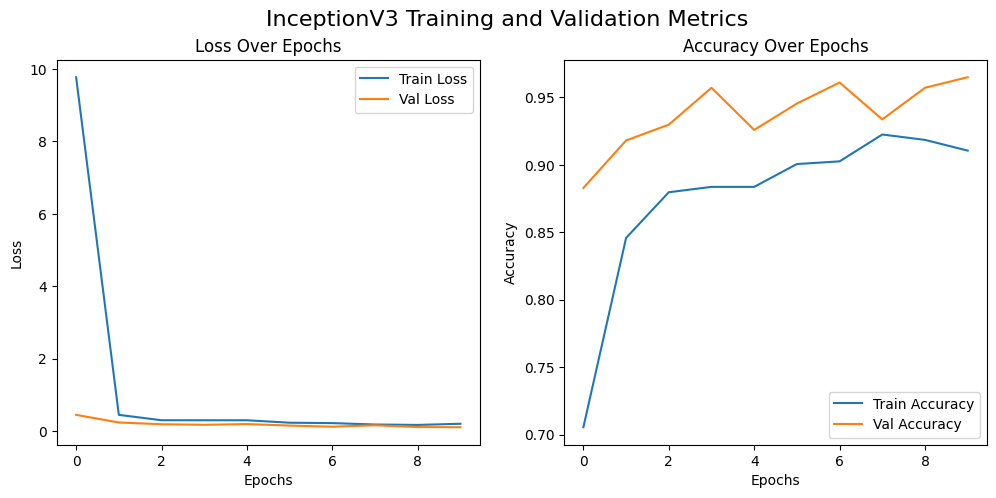

9/9 [==============================] - 1s 71ms/step
MobileNetV2 - Mean Squared Error (MSE): 0.0038461538461538464
MobileNetV2 - Root Mean Squared Error (RMSE): 0.06201736729460423


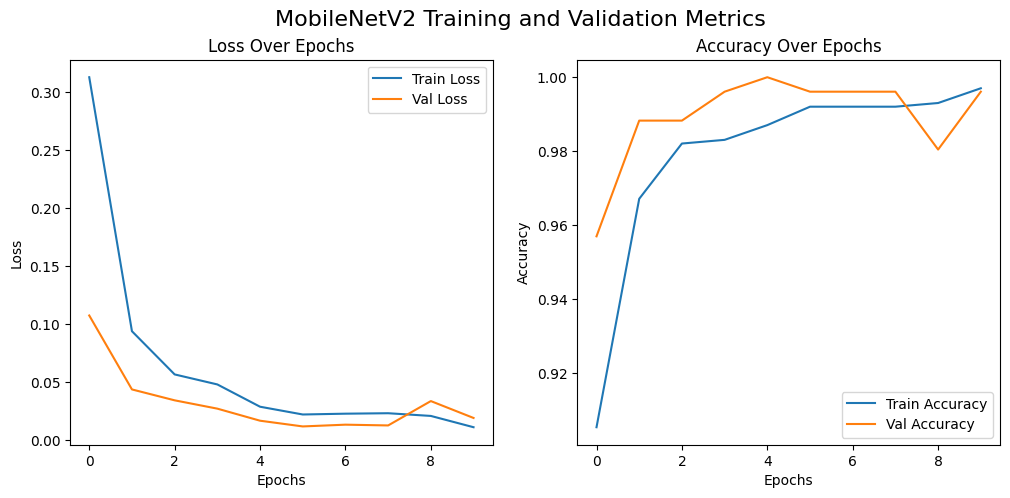

9/9 [==============================] - 4s 219ms/step
DenseNet121 - Mean Squared Error (MSE): 0.011538461538461539
DenseNet121 - Root Mean Squared Error (RMSE): 0.10741723110591493


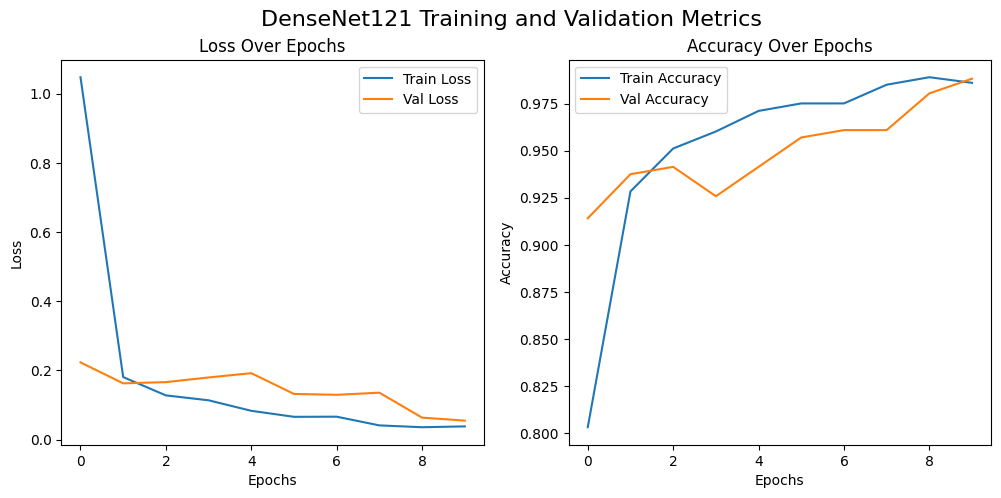

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
from tensorflow.keras.models import load_model

# Model names to load and evaluate
model_names = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2', 'DenseNet121']

# Dictionary to store MSE and RMSE results
mse_rmse_results = {}

for model_name in model_names:
    # Load the trained model and history
    model = load_model(f"{model_name}_Tumor_detection.h5")
    
    with open(f"{model_name}_history.pkl", 'rb') as file:
        history = pickle.load(file)

    # Predictions and evaluations
    predictions = model.predict(valX, batch_size=32)
    predictions = np.argmax(predictions, axis=1)
    actuals = valY

    # MSE and RMSE calculations
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mse_rmse_results[model_name] = (mse, rmse)
    
    print(f"{model_name} - Mean Squared Error (MSE): {mse}")
    print(f"{model_name} - Root Mean Squared Error (RMSE): {rmse}")

    # Plotting training/validation loss and accuracy
    epochs_range = np.arange(len(history['loss']))
    
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{model_name} Training and Validation Metrics', fontsize=16)

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['loss'], label="Train Loss")
    plt.plot(epochs_range, history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['accuracy'], label="Train Accuracy")
    plt.plot(epochs_range, history['val_accuracy'], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f"{model_name}_training_plot.jpg")
    plt.show()

# Optionally, save MSE and RMSE results for future reference
with open("mse_rmse_results.txt", "w") as file:
    for model_name, (mse, rmse) in mse_rmse_results.items():
        file.write(f"{model_name} - MSE: {mse}, RMSE: {rmse}\n")



Loaded model: VGG16
9/9 [==============================] - 2s 240ms/step

Classification Report for VGG16:

              precision    recall  f1-score   support

Normal Brain       1.00      0.86      0.92        76
       Tumor       0.94      1.00      0.97       184

    accuracy                           0.96       260
   macro avg       0.97      0.93      0.95       260
weighted avg       0.96      0.96      0.96       260



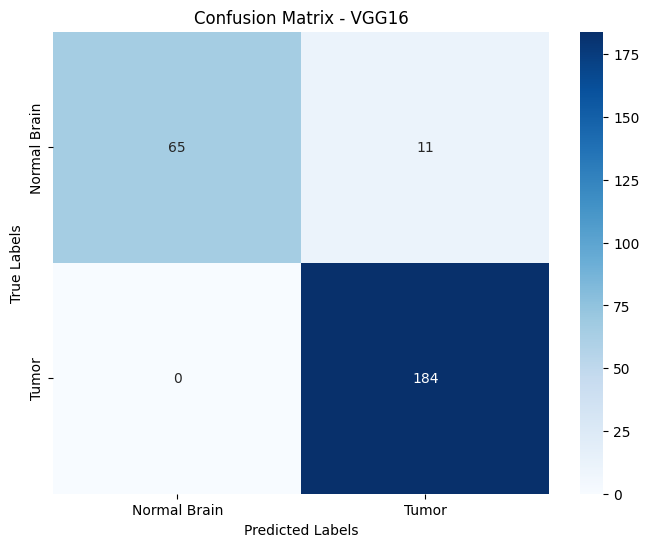

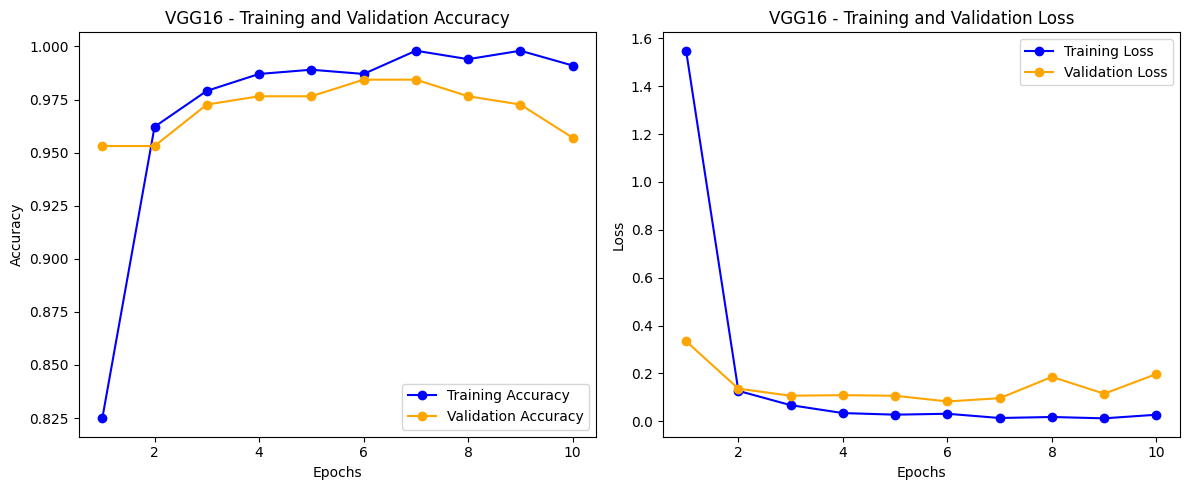

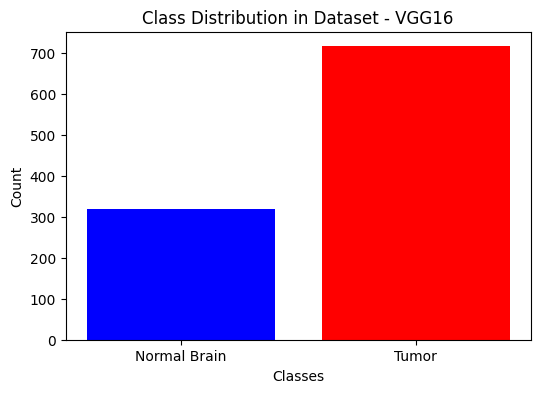

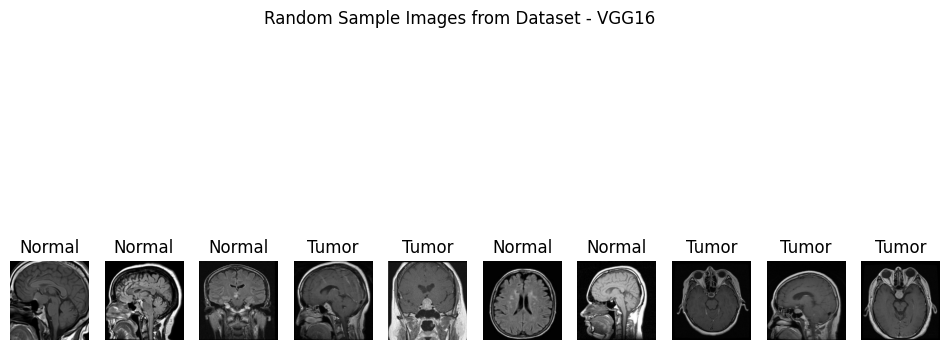


Loaded model: ResNet50
9/9 [==============================] - 2s 167ms/step

Classification Report for ResNet50:

              precision    recall  f1-score   support

Normal Brain       1.00      0.95      0.97        76
       Tumor       0.98      1.00      0.99       184

    accuracy                           0.98       260
   macro avg       0.99      0.97      0.98       260
weighted avg       0.98      0.98      0.98       260



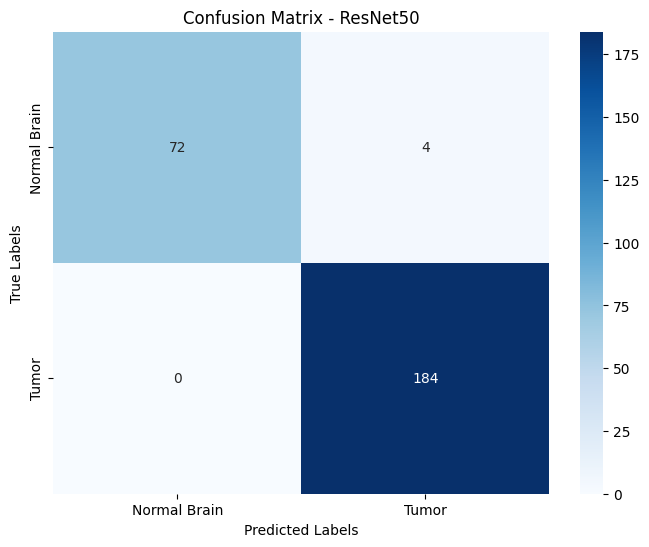

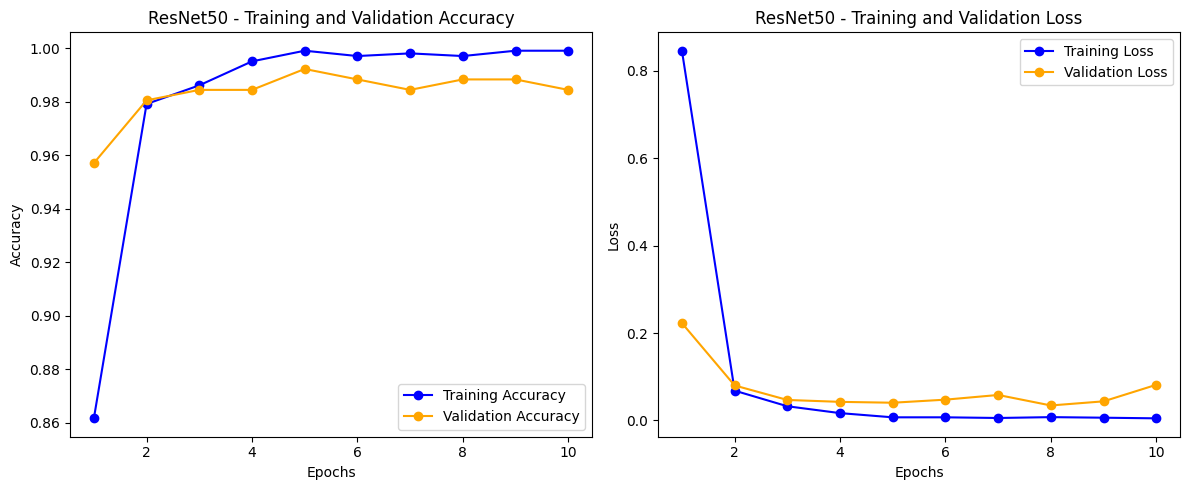

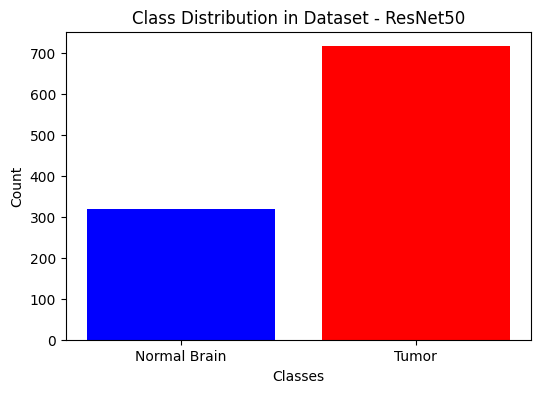

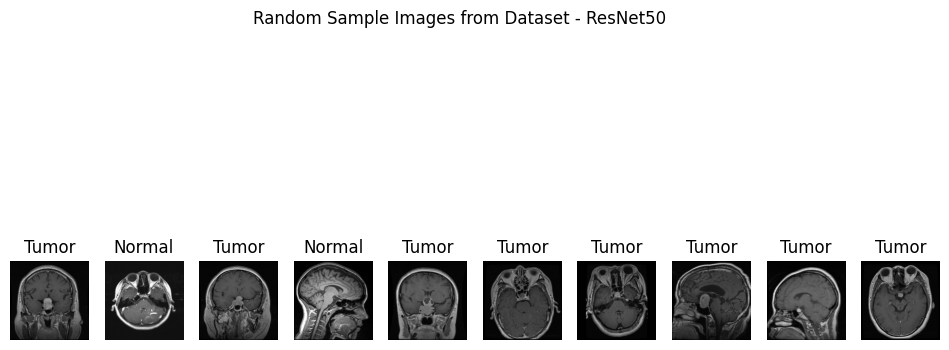


Loaded model: InceptionV3
9/9 [==============================] - 3s 179ms/step

Classification Report for InceptionV3:

              precision    recall  f1-score   support

Normal Brain       0.97      0.91      0.94        76
       Tumor       0.96      0.99      0.98       184

    accuracy                           0.97       260
   macro avg       0.97      0.95      0.96       260
weighted avg       0.97      0.97      0.97       260



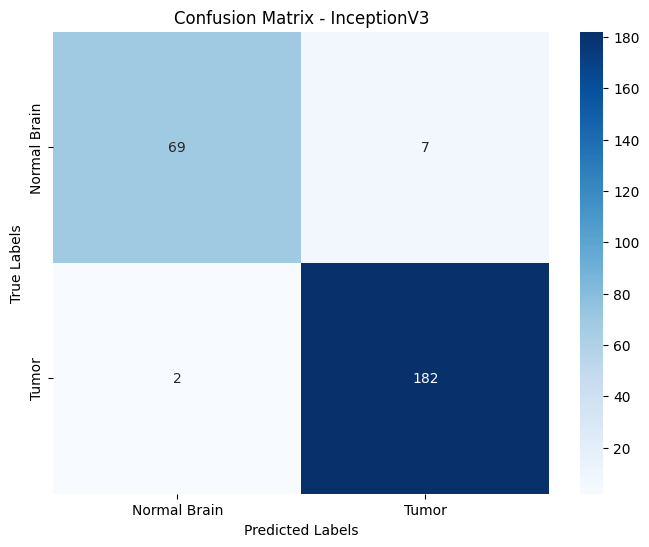

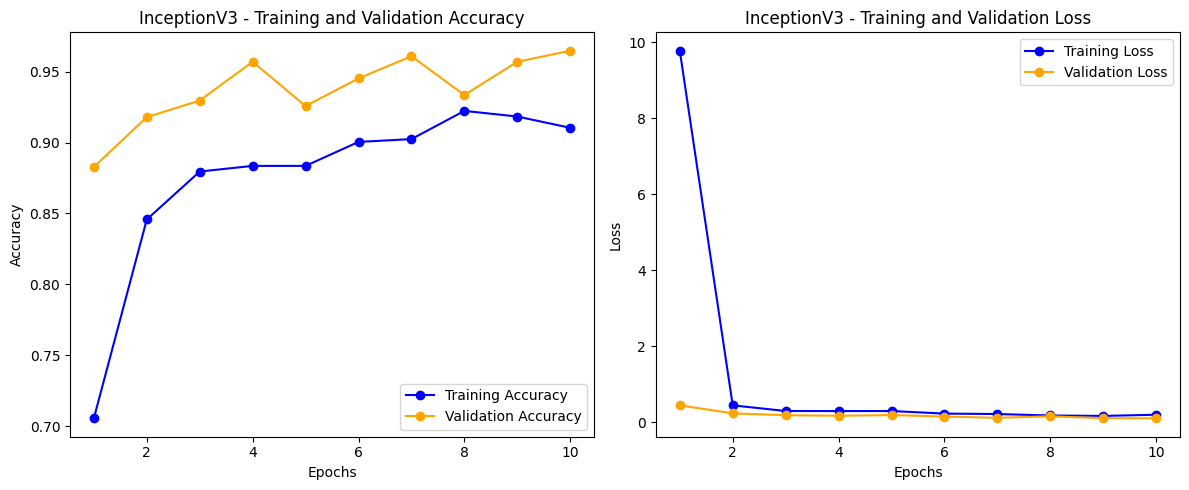

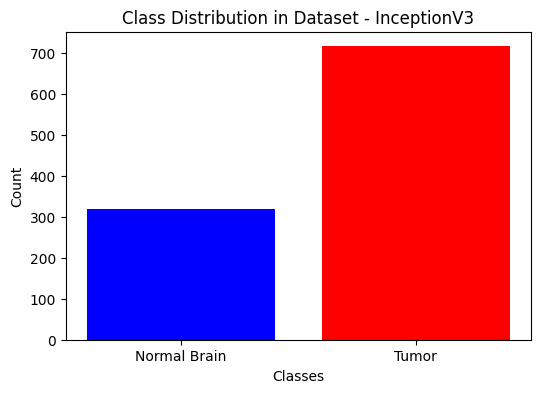

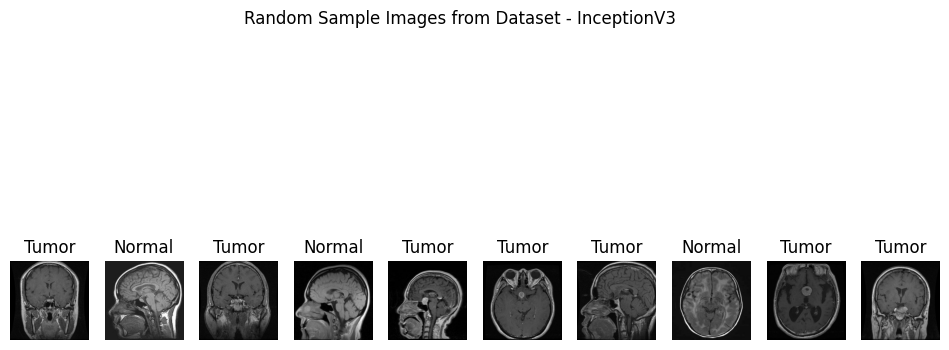


Loaded model: MobileNetV2
9/9 [==============================] - 1s 77ms/step

Classification Report for MobileNetV2:

              precision    recall  f1-score   support

Normal Brain       1.00      0.99      0.99        76
       Tumor       0.99      1.00      1.00       184

    accuracy                           1.00       260
   macro avg       1.00      0.99      1.00       260
weighted avg       1.00      1.00      1.00       260



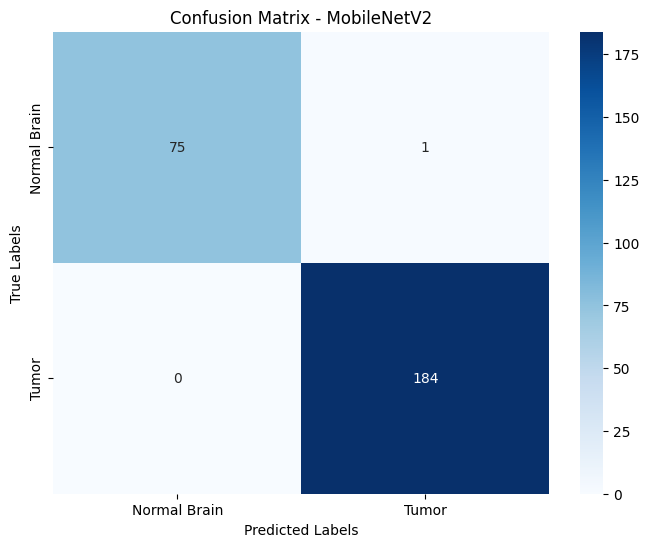

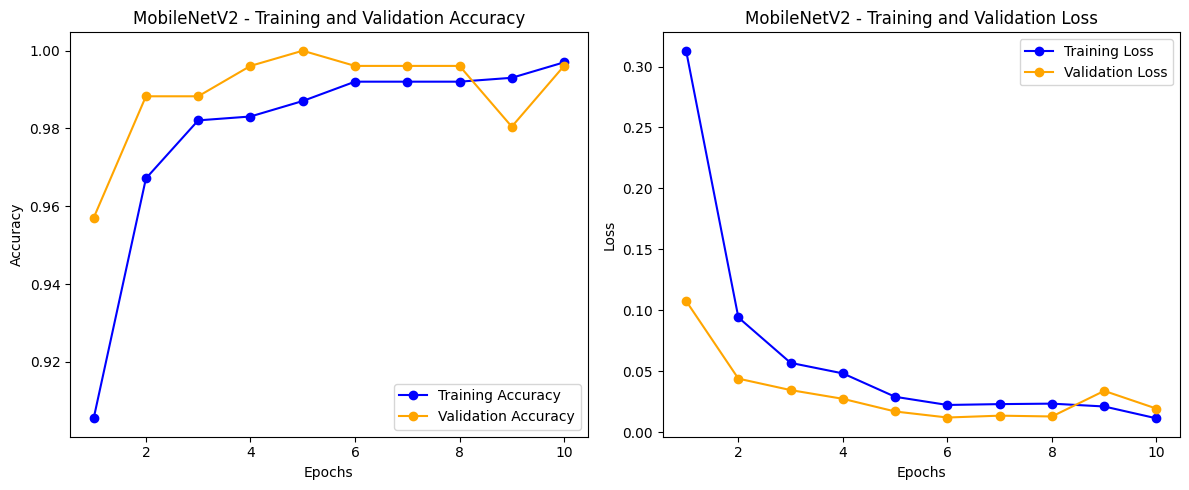

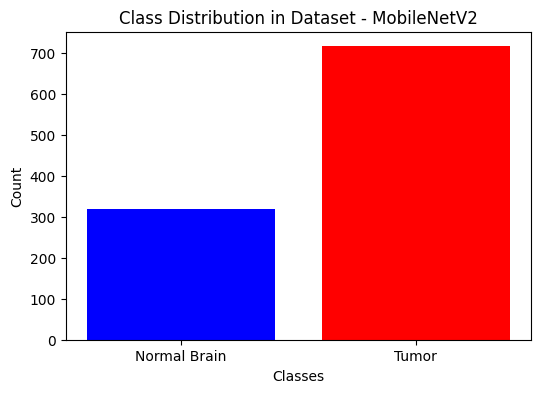

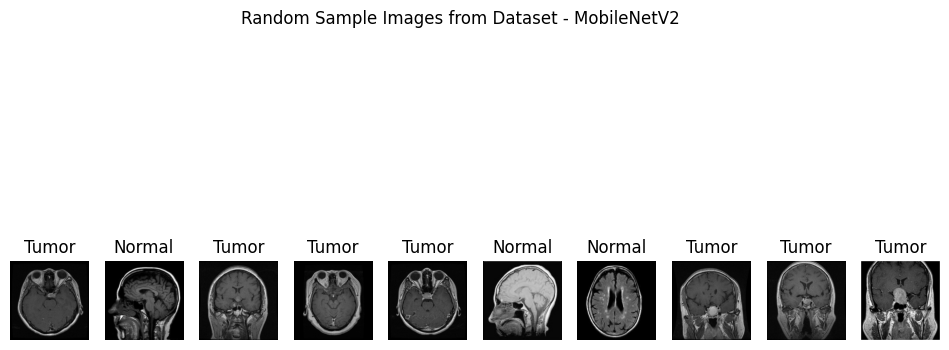


Loaded model: DenseNet121
9/9 [==============================] - 4s 214ms/step

Classification Report for DenseNet121:

              precision    recall  f1-score   support

Normal Brain       0.99      0.97      0.98        76
       Tumor       0.99      0.99      0.99       184

    accuracy                           0.99       260
   macro avg       0.99      0.98      0.99       260
weighted avg       0.99      0.99      0.99       260



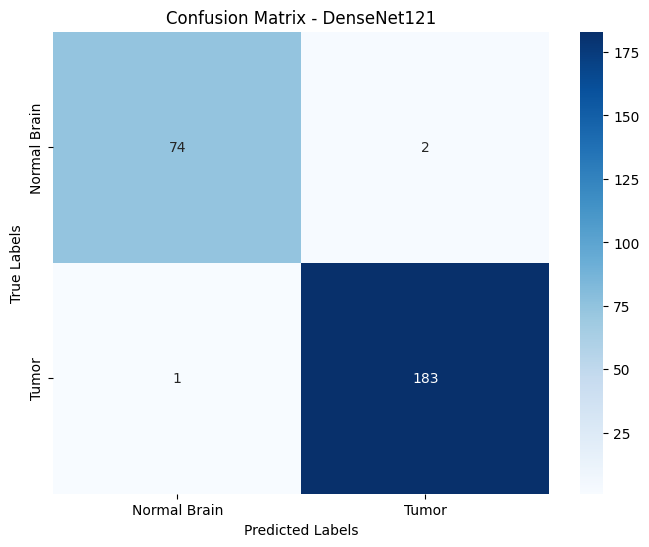

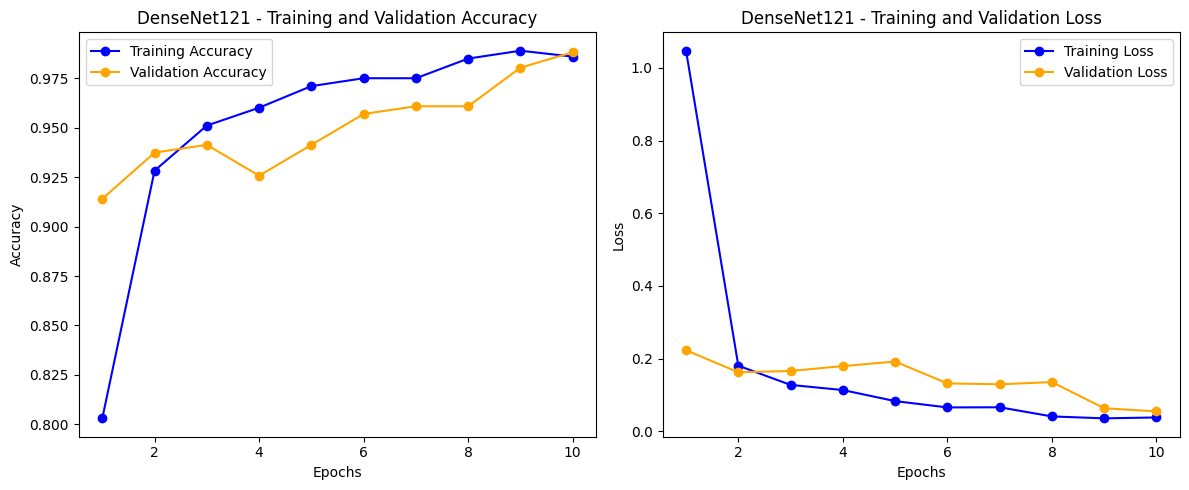

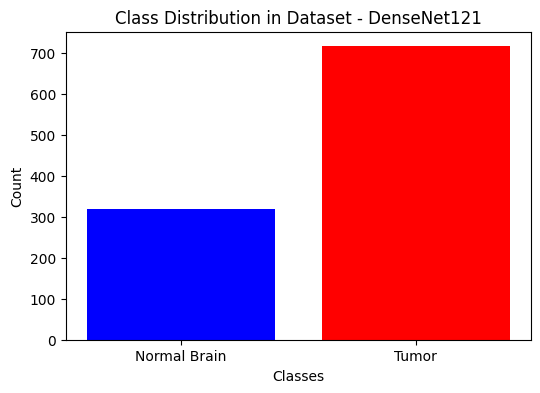

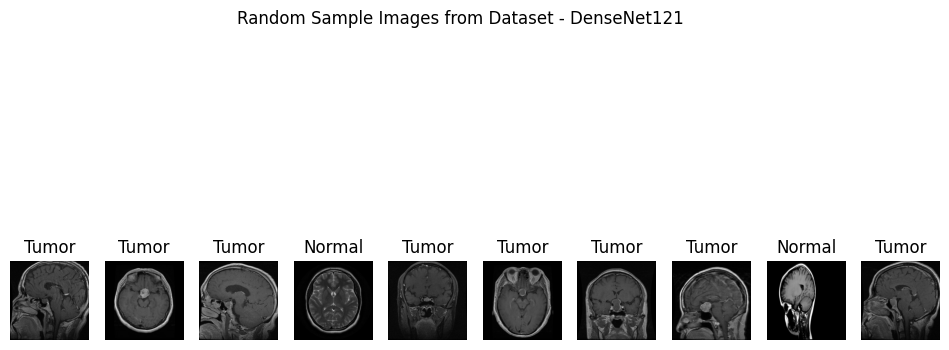

In [ ]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# List of model names we are working with
model_names = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2', 'DenseNet121']
class_labels = ["Normal Brain", "Tumor"]

# Loop through each model to load, predict, and evaluate
for model_name in model_names:
    # Load the trained model
    model = load_model(f"{model_name}_Tumor_detection.h5")
    print(f"\nLoaded model: {model_name}")

    # Load the training history for this model
    with open(f"{model_name}_history.pkl", 'rb') as file:
        history = pickle.load(file)

    # Make predictions on the validation data
    val_predictions = model.predict(valX, batch_size=batch_size)
    val_predictions = np.argmax(val_predictions, axis=1)
    
    # Compute confusion matrix and classification report
    conf_matrix = confusion_matrix(valY, val_predictions)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(valY, val_predictions, target_names=class_labels, zero_division=1))
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    
    # Plot training and validation accuracy and loss
    epochs = range(1, len(history['accuracy']) + 1)
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', marker='o')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # -- New Feature 1: Plotting Class Distribution --
    unique, counts = np.unique(trainY, return_counts=True)
    label_distribution = dict(zip(unique, counts))

    plt.figure(figsize=(6, 4))
    plt.bar(label_distribution.keys(), label_distribution.values(), color=['blue', 'red'])
    plt.xticks(ticks=[0, 1], labels=['Normal Brain', 'Tumor'])
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(f'Class Distribution in Dataset - {model_name}')
    plt.show()

    # -- New Feature 2: Display Random Sample Images --
    num_images = 10  # Number of images to display

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        idx = random.randint(0, len(trainX) - 1)
        img = trainX[idx]
        label = "Tumor" if trainY[idx] == 1 else "Normal"
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.suptitle(f"Random Sample Images from Dataset - {model_name}")
    plt.show()


VGG16 Final Validation Accuracy: 0.9570
ResNet50 Final Validation Accuracy: 0.9844
InceptionV3 Final Validation Accuracy: 0.9648
MobileNetV2 Final Validation Accuracy: 0.9961
DenseNet121 Final Validation Accuracy: 0.9883


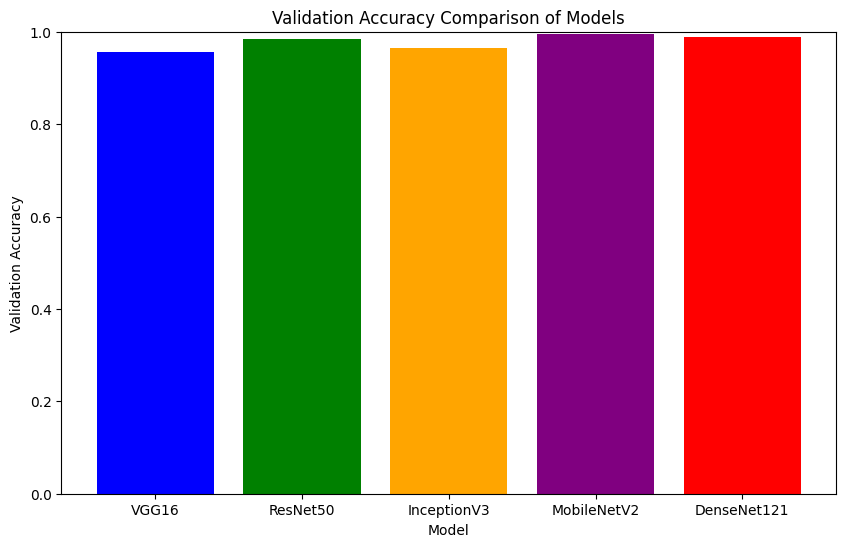

In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# List of model names
model_names = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2', 'DenseNet121']
final_val_accuracies = []

# Loop through each model to load the history and extract the final validation accuracy
for model_name in model_names:
    # Load the training history for this model
    with open(f"{model_name}_history.pkl", 'rb') as file:
        history = pickle.load(file)
    
    # Extract the final validation accuracy
    final_val_accuracy = history['val_accuracy'][-1]  # Last value of validation accuracy
    final_val_accuracies.append(final_val_accuracy)
    print(f"{model_name} Final Validation Accuracy: {final_val_accuracy:.4f}")

# Plotting the validation accuracies in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, final_val_accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison of Models')
plt.ylim(0, 1)  # Adjust based on accuracy scale (e.g., 0 to 1 if normalized)
plt.show()
